<p> Run a simulation of filling in a network based on the 7 de Septiembre neighborhood layout in Araijan </p>
<p>**(.inp and .config files already written)**</p>
<p> Below you see how to:</p>
<ul>
<li>Set boundary and initial conditions </li>
<li>Run a simulation until time T= 1200 s</li>
<li>plot time series of pressure head at different points in a single pipe</li>
<li>plot time series of pressure head at sample points in various pipes</li>
<li>plot space dependence of pressure head at a certain time</li>
<li>look at velocities</li>
<li>plot network layout</li>
</ul>

In [12]:
#import modules for simulation and plotting
import sys  #for importing files you need
sys.path.append("..")  
from allthethings import PyNetwork, PyPipe_ps   #network and pipe classes
import numpy as np                              #for generally doing math
import matplotlib.pyplot as plt                 #for plotting
%pylab inline                                   
from writeit import *

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [13]:
#specify input files
fi = "../indata/7deSeptiembre.inp"    
fc = "../indata/7deSeptiembre.config" 
mtype = 1                             #model type. set =0 for uniform cross-section channel flow (has not been tested for awhile)
#create a network 
n1 = PyNetwork(fi,fc,mtype)
#show the layout of the network
n1.showLayout()

   pipe | start node | end node
-----------------------------------
     0  |  0         | 1
     1  |  1         | 2
     2  |  2         | 3
     3  |  3         | 4
     4  |  4         | 5
     5  |  5         | 7
     6  |  7         | 8
     7  |  5         | 6
     8  |  4         | 9
     9  |  3         | 8
     10  |  8         | 10
     11  |  10         | 11
     12  |  11         | 12
     13  |  11         | 13


   node | #incoming pipes
-------------------------
  0     |  1
  1     |  2
  2     |  2
  3     |  3
  4     |  3
  5     |  3
  6     |  1
  7     |  2
  8     |  3
  9     |  1
  10     |  2
  11     |  3
  12     |  1
  13     |  1


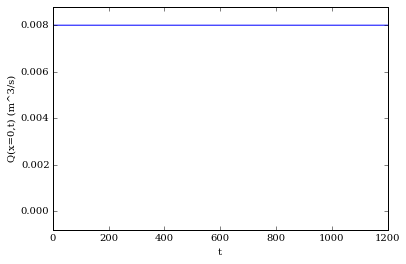

In [16]:
#create time series Q(x=0, t) = q0 for t<T/2, 0 for t>=T/2
q0 = 0.008 #inflow boundary value (m^3/s)
M = n1.M   #number of time steps
T = n1.T   #simulation length (in seconds)
Q0 = q0*np.ones(M+1);            
#for i in range(M/2,M+1):        
#    Q0[i] = 0

#look at this time series
t = linspace(0,n1.T,M+1)
plot(t,Q0)
ylim(-.1*Q0[0],1.1*Q0[0]) 
xlabel('t')
ylabel('Q(x=0,t) (m^3/s)')
#assign this inflow pattern as a boundary condition for junction 0 (at the left end of pipe 0)
n1.setbVal(0,Q0)
# set initial condition to (H = 10m, Q = Q0) in pipe 0, 'empty' everywhere else)
#make a single pipe "PyPipe" to evalute correct cross-sectional area corresponding to H = 10m
p1 = PyPipe_ps(n1.Ns[0], n1.Ds[0],n1.Ls[0], M, n1.a[0])  
h0 = p1.AofH(10,False)
A00 = h0*np.ones(n1.Ns[0])
Q00 = Q0[0]*np.ones(n1.Ns[0])
n1.setIC(0,A00,Q00)
A00 = h0*np.ones(n1.Ns[1])
Q00 = Q0[0]*np.ones(n1.Ns[1])
n1.setIC(1,A00,Q00)
Np = n1.Nedges # number of pipes
for k in range(2,Np):
    A00 = 0.001*n1.Ds[k]*np.ones(n1.Ns[k])  #set other pipes to 1e-3*(pipe diameter) to avoid near-zero roundoff issues
    Q00 = np.zeros(n1.Ns[k])
    n1.setIC(k, A00, Q00)

In [17]:
# uncomment line below to take a look at initial conditions before starting simulation
#n1.showCurrentData()

In [18]:
#Run the simulation!
dt = T/float(M)#time step
V0 = n1.getTotalVolume()
n1.runForwardProblem(dt)


In [19]:
m32gal = 264.172   #conversion factor, m^3 to gallons
m2psi = 1.42       #conversion factor, m of pressure head to psi
mdx = min([n1.Ls[i]/n1.Ns[i] for i in range(n1.Nedges)])
#print timing information
print "Simulated time T = %f s" %n1.T
print "Solve time = %f  s" %n1.solve_time
print "dt = %f" %dt
print "inflow volume = %.2f gallons" % ((n1.getTotalVolume()-V0)*m32gal)
print "pressure wave speed is %f m/s"% (max(n1.a))
print "CFL = 1/(dx/dt)*(max wave speed) = %f" % (max(n1.cmax)*dt/mdx)

Simulated time T = 1200.000000 s
Solve time = 86.892227  s
dt = 0.054545
inflow volume = 104018.99 gallons
pressure wave speed is 100.000000 m/s
CFL = 1/(dx/dt)*(max wave speed) = 0.641795


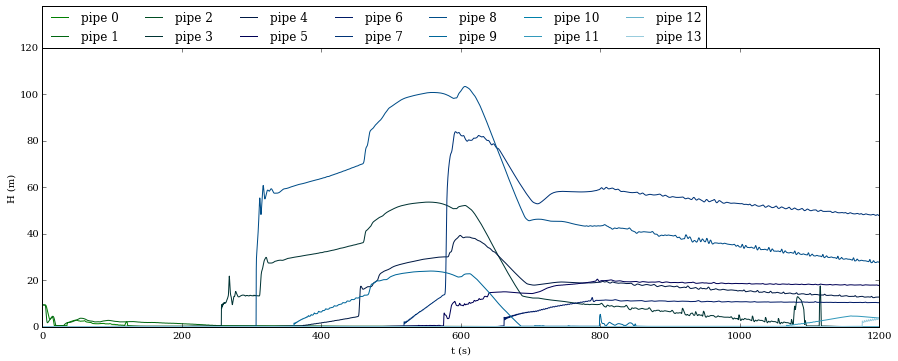

In [20]:
#show time series at a sensor in the middle of each pipe in the network
# import a nice colormap
from matplotlib import cm
import matplotlib.colors as colors
cNorm  = colors.Normalize(vmin=0, vmax=Np+1)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('ocean') )
fig = figure(figsize= (15,5))
t = linspace(0,T,M+1)
interesting = arange(0,Np) #pipes you are interested in (currently all)
for i in interesting: 
    #look at pressure time series in i^th pipe, pbar(A(X*, t)), where X* = L/2 for pipe length L, and t =0, dt, 2*dt,...dt*M
    P1 = n1.pressureTimeSeries(i,n1.Ns[i]/2-1) 
    plot(t,P1,color =scalarMap.to_rgba(i), label = "pipe %d" %i) 
legend(ncol=7, loc = (0,1))
ax = gca()
ax.set_xlabel('t (s)')
ax.set_ylabel('H (m)')

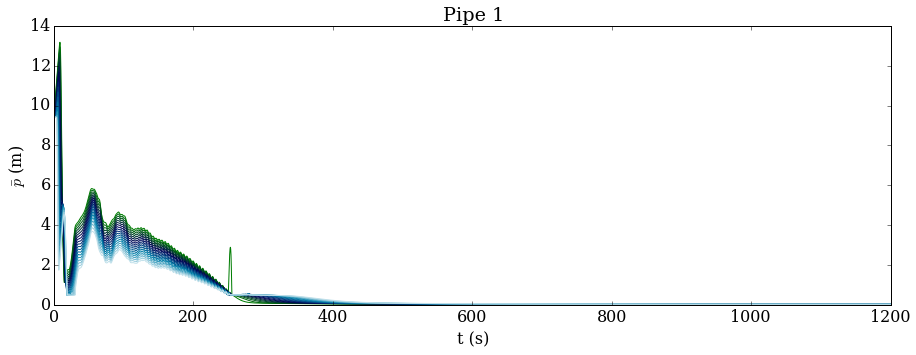

In [24]:
#show pressure time series at different locations along the length of a single pipe
i = 1  #pipe number you want to look at
fig = figure(figsize= (15,5))
#new color map
xs = np.arange(1,n1.Ns[i]+1,2)
cNorm  = colors.Normalize(vmin=0, vmax=xs[-1]+10)
scalarMap = cm.ScalarMappable(norm=cNorm, cmap=cm.get_cmap('ocean') )
t = np.linspace(0,n1.T,M+1)
for J in range(0,len(xs),3):
    cval = scalarMap.to_rgba(xs[J])
    dx = n1.Ls[i]/float(n1.Ns[i])
    P2 = n1.pressureTimeSeries(i,J)
    q=plot(t,P2,color =cval,label="x = %.1f"%(dx*xs[J]))
ax = gca()
ax.set_title('Pipe %d'%i)
ax.set_xlabel('t (s)')
ax.set_ylabel(r'$\bar{p}$ (m)')
#legend(loc = 'upper left')
#savefig("../sensors_pipe%d.eps"%i, format='eps')

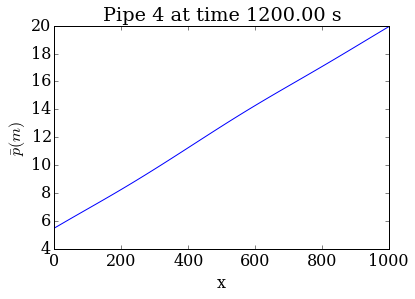

In [29]:
#show how pressure profile varies in space at the end of the run 
i = 4  # pipe you want to look at
m = M  #time slice you want to look at
Px = n1.pressureSpaceSeries(i,m)
x = linspace(0,n1.Ls[i],n1.Ns[i])
plot(x,Px)
title('Pipe %d at time %.2f s'%(i,dt*m))
xlabel('x')
ylabel(r'$\bar{p}(m)$')

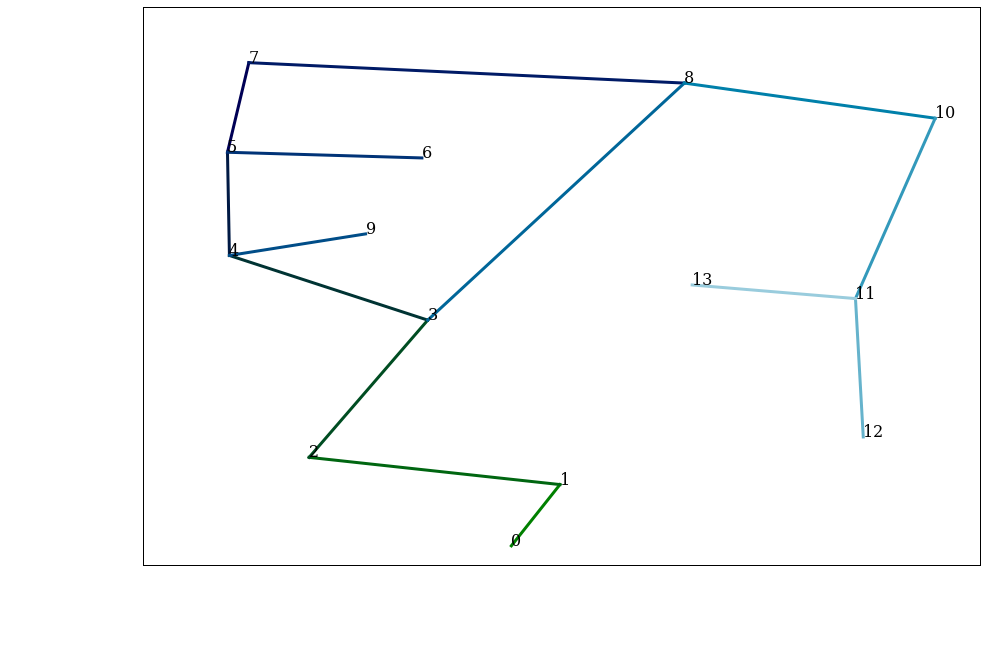

In [30]:
#plot network layout
(xs,ys,conns,ls) = getBasicConnectivity(fi)
Np = shape(conns)[0]
plotNetworkLayout(xs,ys,conns,ls,Np)